## Explore MTA Data

In [1]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
#%matplotlib notebook
%matplotlib inline

import csv
from collections import defaultdict
import re

In [2]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

### Useful Functions for Data Standardization

In [3]:
def clean_cols(df):
    for col in df.columns:
        # Clean the string type data
        if df[col].dtype == 'object':
            df[col]= df[col].str.strip()
    return df

def make_standard_names(df):
    # Clean up the column names
    cols = df.columns
    for col in cols:
        col_new = col
        col_new = col_new.lower()
        col_new = col_new.strip()
        col_new = col_new.replace('/','')
        col_new = col_new.replace(' ','_')
        df = df.rename(columns = {col: col_new})
    return df

### NYC Transit Subway Entrance And Exit Data


In [4]:
# This data file provides a variety of information on subway station entrances and exits which includes but is not limited to: 
# Division, Line, Station Name, Longitude and Latitude coordinates of entrances/exits.
nyc_entr_exit = pd.read_csv("https://data.ny.gov/api/views/i9wp-a4ja/rows.csv")

In [5]:
#print(nyc_entr_exit.info())

In [6]:
nyc_entr_exit.sample(5)

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,Route6,Route7,Route8,Route9,Route10,Route11,Entrance Type,Entry,Exit Only,Vending,Staffing,Staff Hours,ADA,ADA Notes,Free Crossover,North South Street,East West Street,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location
317,IND,8 Avenue,86th St,40.786,-73.969,B,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,Central Park West,86th St,NW,40.785,-73.969,"(40.785868, -73.968916)","(40.785480, -73.969458)"
747,IRT,Broadway-7th Ave,Christopher St,40.733,-74.003,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,NONE,NaN,False,NaN,False,7th Ave,Christopher St,NW,40.734,-74.003,"(40.733422, -74.002906)","(40.733652, -74.003006)"
445,BMT,Brighton,Ocean Parkway,40.576,-73.969,Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,NONE,NaN,False,NaN,True,Ocean Pkwy,Brighton Beach Rd,NW,40.576,-73.969,"(40.576312, -73.968501)","(40.576487, -73.969243)"
660,IRT,Broadway-7th Ave,207th St,40.865,-73.919,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,False,10th Ave,207th St,SW,40.864,-73.919,"(40.864614, -73.918819)","(40.864283, -73.919222)"
577,BMT,Broadway Jamaica,Elderts Lane-75th St,40.691,-73.867,J,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,75th St,Jamaica,NW,40.691,-73.867,"(40.691324, -73.867139)","(40.691479, -73.866610)"


### Turnstile Usage Data 2017

Currently openting a single file over a two week period for MTA turnstyle data. To run on local machine, set up paths in the same way, or change the string to appropriate location

In [7]:
### Turnstile Usage Data: 2017
# State of New York — Data file contains information on entry/exit register values for individual control areas.
nyc_turnstile_2017 = pd.read_csv('turnstile_data/turnstile_170617.txt')
#nyc_turnstile_2017 = pd.read_csv("https://data.ny.gov/api/views/v5y5-mwpb/rows.csv")
#nyc_turnstile_2017 = pd.read_csv('turnstile_data/Turnstile_Usage_Data__2017.csv')


### Clean Data and create useful columns

In [101]:
#strip away white space from data and standardize names
#some files have names in all caps, and other do not.
nyc_turnstile_2017 = clean_cols(nyc_turnstile_2017)
nyc_turnstile_2017 = make_standard_names(nyc_turnstile_2017)

#Make a column with real timestamps (date and time)
nyc_turnstile_2017['readtime'] = nyc_turnstile_2017['date'] + ' ' + nyc_turnstile_2017['time']
nyc_turnstile_2017['readtime'] = pd.to_datetime(nyc_turnstile_2017['readtime'], format='%m/%d/%Y %H:%M:%S')

# Create a unique "Meter Name"
# 'ca', 'unit','scp' comprise a unique "meters".
# There can be several "meters" at each station. This these can be recombined using "Group By"
nyc_turnstile_2017['id'] = nyc_turnstile_2017['ca']+'_'+nyc_turnstile_2017['unit']+'_'+nyc_turnstile_2017['scp']
nyc_turnstile_2017['entries_diff'] = nyc_turnstile_2017['entries'].diff()
nyc_turnstile_2017['exits_diff'] = nyc_turnstile_2017['exits'].diff()


# Clean up jump that results in diff when going from one meter to another
# To do this, I converted the "ids", exits, and entries to lists, and the I
# I used a simple "for loop".
id_list = list(nyc_turnstile_2017['id'])
entries_diff_list = list(nyc_turnstile_2017.entries_diff)
exits_diff_list = list(nyc_turnstile_2017.exits_diff)

for ix, val in enumerate(id_list):
    if ix!= 0:
        if id_list[ix]!= id_list[ix-1]:
            entries_diff_list[ix] = np.nan
            exits_diff_list[ix] = np.nan

# Do some additional filtering based on a maximum expected value
# determined by looking at Time Square data

upper_limit = 50000 # somewhat arbitrary
for ix, val in enumerate(entries_diff_list):
    if val> upper_limit:
        entries_diff_list[ix] = np.nan
    elif val<0:
        entries_diff_list[ix] = np.nan
        
for ix, val in enumerate(exits_diff_list):
    if val> upper_limit:
        exits_diff_list[ix] = np.nan
    elif val<0:
        exits_diff_list[ix] = np.nan
entries_diff_df = pd.DataFrame(data = entries_diff_list, index = nyc_turnstile_2017.index)
exits_diff_df = pd.DataFrame(data = exits_diff_list, index = nyc_turnstile_2017.index)

nyc_turnstile_2017['entries_diff_cleaned'] = entries_diff_df
nyc_turnstile_2017['exits_diff_cleaned'] = exits_diff_df

Create a Data Frame that is multi-indexed on "id" and time-stamp. This might be overkill, and it might be better to not use multi-indexing

In [102]:
nyc_turnstile_2017_grouped = nyc_turnstile_2017.set_index(['id','readtime'])
#nyc_turnstile_2017_grouped

### Get a unique list of "meters"

In [103]:
ids = nyc_turnstile_2017['id'].unique()

### Pick a random "meter" and plot the results

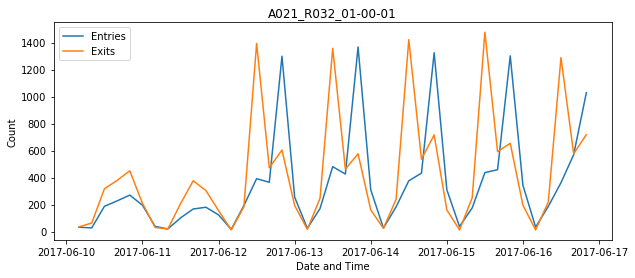

In [104]:
test_turn = random.randint(0,len(ids))

test_id_df = nyc_turnstile_2017[nyc_turnstile_2017['id'] == ids[test_turn]]

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(test_id_df['readtime'],test_id_df.entries_diff_cleaned)
plt.plot(test_id_df['readtime'],test_id_df.exits_diff_cleaned)
#plt.set_xlabel('Date Time')
#plt.set_ylabel('Exits')
plt.legend(['Entries','Exits'])
plt.xlabel('Date and Time')
plt.ylabel('Count')
plt.title(ids[test_turn])

### Look at Entries and Exits at one particular station: Times Square

In [105]:
station_series = pd.Series(nyc_turnstile_2017['station'].unique())

In [106]:
# lets get a list of 42nd street stations
station_series[station_series.str.contains('42')]

4       TIMES SQ-42 ST
131    42 ST-PORT AUTH
210    42 ST-BRYANT PK
277    GRD CNTRL-42 ST
dtype: object

In [107]:
test_df= nyc_turnstile_2017[nyc_turnstile_2017['station'] == 'TIMES SQ-42 ST']
test_df = test_df.groupby('readtime').sum()

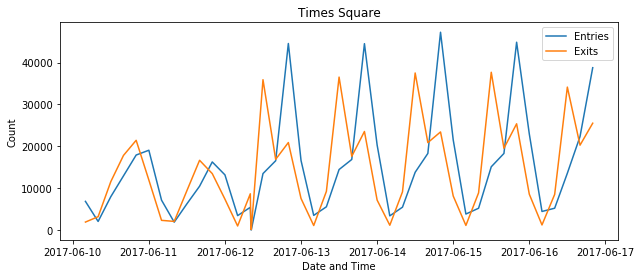

In [108]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(test_df.index,test_df.entries_diff_cleaned)
plt.plot(test_df.index,test_df.exits_diff_cleaned)
#plt.set_xlabel('Date Time')
#plt.set_ylabel('Exits')
plt.title('Times Square')
plt.legend(['Entries','Exits'])
plt.xlabel('Date and Time')
plt.ylabel('Count')

This map is usful. Given that time square is one of the busiest stations, this gives us an upper limit for filtering "bad" values. Based on this plot, it is reasonable to expect that  exit and entry counts for an __individual turnstile__ over 50 should be excluded

### Histogram of station usuage over one week period

In [112]:
summed_df = nyc_turnstile_2017.groupby('station').sum()
summed_df.sort_values(['entries_diff_cleaned'],ascending=False)

,entries,exits,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned
station,,,,,,
34 ST-PENN STA,1.184e+11,6.711e+10,6.979e+07,-1.160e+08,1.028e+06,873993.0
GRD CNTRL-42 ST,1.383e+11,1.122e+11,-1.180e+08,-7.176e+05,8.724e+05,798127.0
34 ST-HERALD SQ,2.295e+11,2.869e+11,7.927e+07,-4.691e+06,7.157e+05,696225.0
23 ST,2.804e+11,3.127e+11,-1.929e+08,-7.215e+08,6.842e+05,513156.0
14 ST-UNION SQ,4.693e+10,1.317e+10,2.207e+07,-6.383e+06,6.665e+05,574303.0
TIMES SQ-42 ST,2.482e+11,1.930e+11,-6.017e+07,-4.638e+07,6.309e+05,595800.0
42 ST-PORT AUTH,3.515e+11,2.897e+11,-3.004e+06,-4.666e+06,5.606e+05,461652.0
FULTON ST,1.731e+11,1.785e+11,2.135e+07,-1.999e+06,5.595e+05,458344.0
86 ST,1.020e+11,1.059e+11,1.188e+08,4.346e+07,5.550e+05,456619.0


### Random Stuff

In [53]:
scp_df = nyc_turnstile_2017['scp'].drop_duplicates()
len(scp_df)

230

In [54]:
scp_station_df = nyc_turnstile_2017[['scp','station']]
scp_station_df = scp_station_df.drop_duplicates()
len(scp_station_df)


4149

In [55]:
#Make hierarchical index
three_col = nyc_turnstile_2017[['ca','unit','scp']].drop_duplicates()
len(three_col)

4695

In [86]:
# Calculate entries and exists per period
"""
nyc_turnstile_2017['entries_diff'] = nyc_turnstile_2017['entries'].diff()
nyc_turnstile_2017['exits_diff'] = nyc_turnstile_2017['exits'].diff()

nyc_turnstile_2017[nyc_turnstile_2017['entries_diff'] < 0] = np.nan
nyc_turnstile_2017[nyc_turnstile_2017['exits_diff'] < 0] = np.nan
nyc_turnstile_2017[nyc_turnstile_2017['entries_diff'] > 10**5] = np.nan
nyc_turnstile_2017[nyc_turnstile_2017['exits_diff'] > 10**5] = np.nan
"""

"\nnyc_turnstile_2017['entries_diff'] = nyc_turnstile_2017['entries'].diff()\nnyc_turnstile_2017['exits_diff'] = nyc_turnstile_2017['exits'].diff()\n\nnyc_turnstile_2017[nyc_turnstile_2017['entries_diff'] < 0] = np.nan\nnyc_turnstile_2017[nyc_turnstile_2017['exits_diff'] < 0] = np.nan\nnyc_turnstile_2017[nyc_turnstile_2017['entries_diff'] > 10**5] = np.nan\nnyc_turnstile_2017[nyc_turnstile_2017['exits_diff'] > 10**5] = np.nan\n"

In [89]:
nyc_turnstile_2017.station.unique()

array(['59 ST', nan, '5 AV/59 ST', '57 ST-7 AV', '49 ST', 'TIMES SQ-42 ST',
       '34 ST-HERALD SQ', '28 ST', '23 ST', '14 ST-UNION SQ', '8 ST-NYU',
       'PRINCE ST', 'CANAL ST', 'CITY HALL', 'CORTLANDT ST', 'RECTOR ST',
       'WHITEHALL S-FRY', 'DELANCEY/ESSEX', 'BOWERY', 'CHAMBERS ST',
       'FULTON ST', 'BROAD ST', '7 AV', 'PARK PLACE', 'BOTANIC GARDEN',
       'PROSPECT PARK', 'PARKSIDE AV', 'CHURCH AV', 'BEVERLEY ROAD',
       'CORTELYOU RD', 'NEWKIRK PLAZA', 'AVENUE H', 'AVENUE J', 'AVENUE M',
       'KINGS HWY', 'AVENUE U', 'NECK RD', 'SHEEPSHEAD BAY',
       'BRIGHTON BEACH', 'OCEAN PKWY', 'BOROUGH HALL', 'JAY ST-METROTEC',
       'DEKALB AV', 'ATL AV-BARCLAY', 'UNION ST', '4AV-9 ST', '25 ST',
       '36 ST', '45 ST', '77 ST', '86 ST', 'BAY RIDGE-95 ST', '8 AV',
       'FT HAMILTON PKY', 'NEW UTRECHT AV', '18 AV', '20 AV', 'BAY PKWY',
       '9 AV', '50 ST', '55 ST', '71 ST', '79 ST', '25 AV', 'BAY 50 ST',
       'CONEY IS-STILLW', 'W 8 ST-AQUARIUM', '6 AV', '3 AV', '1 AV'

In [84]:
# plot one sample timeseries
single_station = nyc_turnstile_2017[nyc_turnstile_2017.station == '59 ST']

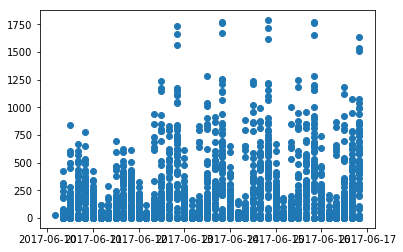

In [85]:
plt.plot(single_station['dtime'],single_station['entries_diff'],marker = 'o',linestyle='None')

In [60]:
nyc_turnstile_2017

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,readtime,id,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned,dtime
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,00:00:00,REGULAR,6.215e+06,2.104e+06,2017-06-10 00:00:00,A002_R051_02-00-00,NaN,NaN,NaN,NaN,2017-06-10 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,04:00:00,REGULAR,6.215e+06,2.104e+06,2017-06-10 04:00:00,A002_R051_02-00-00,26.0,6.0,26.0,6.0,2017-06-10 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,08:00:00,REGULAR,6.215e+06,2.104e+06,2017-06-10 08:00:00,A002_R051_02-00-00,34.0,34.0,34.0,34.0,2017-06-10 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,12:00:00,REGULAR,6.215e+06,2.104e+06,2017-06-10 12:00:00,A002_R051_02-00-00,157.0,80.0,157.0,80.0,2017-06-10 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,16:00:00,REGULAR,6.216e+06,2.104e+06,2017-06-10 16:00:00,A002_R051_02-00-00,366.0,48.0,366.0,48.0,2017-06-10 16:00:00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,20:00:00,REGULAR,6.216e+06,2.104e+06,2017-06-10 20:00:00,A002_R051_02-00-00,433.0,34.0,433.0,34.0,2017-06-10 20:00:00
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2017,00:00:00,REGULAR,6.217e+06,2.105e+06,2017-06-11 00:00:00,A002_R051_02-00-00,259.0,22.0,259.0,22.0,2017-06-11 00:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2017,04:00:00,REGULAR,6.217e+06,2.105e+06,2017-06-11 04:00:00,A002_R051_02-00-00,43.0,10.0,43.0,10.0,2017-06-11 04:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2017,08:00:00,REGULAR,6.217e+06,2.105e+06,2017-06-11 08:00:00,A002_R051_02-00-00,24.0,18.0,24.0,18.0,2017-06-11 08:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2017,12:00:00,REGULAR,6.217e+06,2.105e+06,2017-06-11 12:00:00,A002_R051_02-00-00,106.0,63.0,106.0,63.0,2017-06-11 12:00:00


In [61]:
ls turnstile_data/

Turnstile_Usage_Data__2016.csv  turnstile_170617.txt
Turnstile_Usage_Data__2017.csv  turnstile_170624.txt
turnstile_170610.txt
